In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime
import time
import predict
import base
import shop_classify as sc

import matplotlib
myfont = matplotlib.font_manager.FontProperties(fname=r'C:/Windows/Fonts/msyh.ttf')
matplotlib.use('qt4agg')  
#指定默认字体  
matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['font.family']='sans-serif'  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus'] = False 

%load_ext autoreload
%autoreload 2

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
#读取休假表
calenders = base.ReadCalendarCSV();
#读取user_pay_count
user_pay_counts = base.ReadUserPayCountCSV();
###读取商家信息
shop_infos = base.ReadShopInfoCSV();
##读取城市名称对照表
city_names = base.ReadCityNameCSV();
#读取开店时间数据
shop_open_dates = base.ReadShopOpenDateCSV();

In [5]:
%reload_ext autoreload

In [6]:
predict_pay_counts = pd.read_csv("./data/dataset/dataset/shop_classify/check/predict/preprocess_data.txt", sep="\t", encoding='UTF-8', index_col=0)

In [13]:
predict_pay_counts.columns = predict_pay_counts.columns.map(lambda str_date:datetime.datetime.strptime(str_date, "%Y-%m-%d"))

In [14]:
predict_pay_counts.columns

DatetimeIndex(['2016-10-11', '2016-10-12', '2016-10-13', '2016-10-14',
               '2016-10-15', '2016-10-16', '2016-10-17', '2016-10-18',
               '2016-10-19', '2016-10-20', '2016-10-21', '2016-10-22',
               '2016-10-23', '2016-10-24', '2016-10-25', '2016-10-26',
               '2016-10-27', '2016-10-28', '2016-10-29', '2016-10-30',
               '2016-10-31'],
              dtype='datetime64[ns]', freq=None)

In [7]:
#ARIMA
#执行ArimaShopClassify_Predict2.R

In [7]:
arima_prediction_df = pd.read_csv("./data/dataset/dataset/shop_classify/check/predict/arima_prediction.txt", sep="\t", encoding='UTF-8', index_col=0)
arima_prediction_df = predict.FixFinalPredict(arima_prediction_df)

In [38]:
def calculateSingleHolidayMeanData(id, shop_open_dates, predict_pay_counts, calenders, week):
    df = predict_pay_counts.loc[id][np.array(range(week * 7, week * 7 + 6))].T;
    df = df.to_frame();
    df.columns = ['count']
    df['holiday'] = calenders.loc[df.index.strftime('%Y-%m-%d')]['daytype'].values
        
    means = {}
    for i in range(1, 6):
        if i != 4:
            temp_df = df[df['holiday'] == i];
            means[i] = temp_df['count'].mean()
    return means;

In [48]:
calculateSingleHolidayMeanData(45, shop_open_dates, predict_pay_counts, calenders, 0)

{1: 26.666666666666668, 2: 48.0, 3: 56.0, 5: 39.0}

In [58]:
def calculateHolidayMeansData(shop_open_dates, predict_pay_counts, calenders):
    shop_mean_dict = {}
    for id in range(1,2001):
        print(id)
        mean_dict = {}
        for week in range(3):
            means = calculateSingleHolidayMeanData(id, shop_open_dates, predict_pay_counts, calenders, week)
            mean_dict[week] = means

        shop_mean_dict[id] = mean_dict;

    return shop_mean_dict;

In [59]:
shop_mean_dict = calculateHolidayMeansData(shop_open_dates, predict_pay_counts, calenders)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [71]:
shop_mean_dict[1][2][1]

217.66666666666666

In [65]:
def getHolidayMeanCount(id, day_type, shop_mean_dict, start_week, end_week, pred_mean=None):
    count = 0;
    for i in range(start_week, end_week):
        count = count + shop_mean_dict[id][i][day_type]

    if pred_mean != None:
        count = count + pred_mean[id][day_type]

    if pred_mean != None:
        return count / (end_week - start_week  + 1);
    else:
        return count / (end_week - start_week)

In [66]:
def initMeanData(shop_mean_dict, first_start, first_end, second_start, second_end, pred_valid=True):
    start_time = pd.to_datetime('2016-11-1')
    end_time = pd.to_datetime('2016-11-7')
    predict_date = pd.date_range(start=start_time, end=end_time, freq='D', normalize=True)
    pridicts = {}
    shop_pred_dict = {}
    for id in range(1, 2001):
        print(id)
        y_Pred = []
        pred_dict = {}
        for date in predict_date:
            daytype = calenders.loc[date.strftime('%Y-%m-%d')]['daytype']
            count = getHolidayMeanCount(id, daytype, shop_mean_dict, first_start, first_end)
            y_Pred.append(count);
            pred_dict[daytype] = count;

        shop_pred_dict[id] = pred_dict;
        pridicts[id] = y_Pred

    start_time = pd.to_datetime('2016-11-8')
    end_time = pd.to_datetime('2016-11-14')
    predict_date = pd.date_range(start=start_time, end=end_time, freq='D', normalize=True)
    for id in range(1, 2001):
        print(id)
        y_Pred = []
        for date in predict_date:
            daytype = calenders.loc[date.strftime('%Y-%m-%d')]['daytype']
            #count = sc.getHolidayMeanCount(id, daytype, shop_mean_dict, 0, 3)
            if pred_valid == True:
                count = getHolidayMeanCount(id, daytype, shop_mean_dict, second_start, second_end, shop_pred_dict)
            else:
                count = getHolidayMeanCount(id, daytype, shop_mean_dict, second_start, second_end)
            pridicts[id].append(count)
    
    pridict_df = pd.DataFrame(pridicts)
    pridict_df = pridict_df.T
    pridict_df = predict.FixFinalPredict(pridict_df)
    return pridict_df;

In [72]:
mean_3_3_3_predict = initMeanData(shop_mean_dict, 0, 3, 0, 3, False)
mean_3_3_2_predict = initMeanData(shop_mean_dict, 0, 3, 1, 3)
mean_3_3_1_predict = initMeanData(shop_mean_dict, 0, 3, 2, 3)
mean_2_2_2_predict = initMeanData(shop_mean_dict, 0, 2, 0, 2, False)
mean_2_2_1_predict = initMeanData(shop_mean_dict, 0, 2, 1, 2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [73]:
names = ['2_2_1', '2_2_2', '3_3_1', '3_3_2', '3_3_3']#最后一个arima已经保存

In [74]:
predictions = []
predictions.append(mean_2_2_1_predict)
predictions.append(mean_2_2_2_predict)
predictions.append(mean_3_3_1_predict)
predictions.append(mean_3_3_2_predict)
predictions.append(mean_3_3_3_predict)

In [76]:
for i in range(len(names)):
    predictions[i].to_csv("./data/dataset/dataset/shop_classify/check/predict/" + names[i] + "_prediction.csv", header=None, index=True, encoding='UTF-8')

In [21]:
predict_dfs = []
mean_evaluation_dfs = []
for i in range(len(names)):
    mean_evaluation_dfs.append(pd.read_csv("./data/dataset/dataset/shop_classify/check/train/" + names[i] + "_evaluation.txt", sep='\t', encoding='UTF-8', index_col=0))
    

OSError: File b'./data/dataset/dataset/shop_classify/check/train/2_2_1_evaluation.txt' does not exist

In [54]:
def plotShopPayCounts(shop_id, date_range, time_range, predicts, evaluations, names):
    counts = base.countShopPayTimePeriods(user_pay_counts, shop_id, date_range, time_range)
    counts['holiday'] = calenders.loc[counts.index.strftime('%Y-%m-%d')]['daytype'].values
    info = shop_infos.ix[shop_id]
    
    f, (ax) = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(counts.index, counts['count'], label="real", color='r')
    
    for i in range(len(names)):
        ax.plot(counts.index, predicts[i].loc[shop_id].values, label=(names[i] + ' ' + str(evaluations[i].loc[shop_id].values)))
    
    print(type(info.cate_3_name))
    plt.title(info.cate_1_name + ' ' + info.cate_2_name + ('' if info.cate_3_name is None else info.cate_3_name), fontproperties=myfont)
    plt.legend()
    plt.show()

<class 'str'>


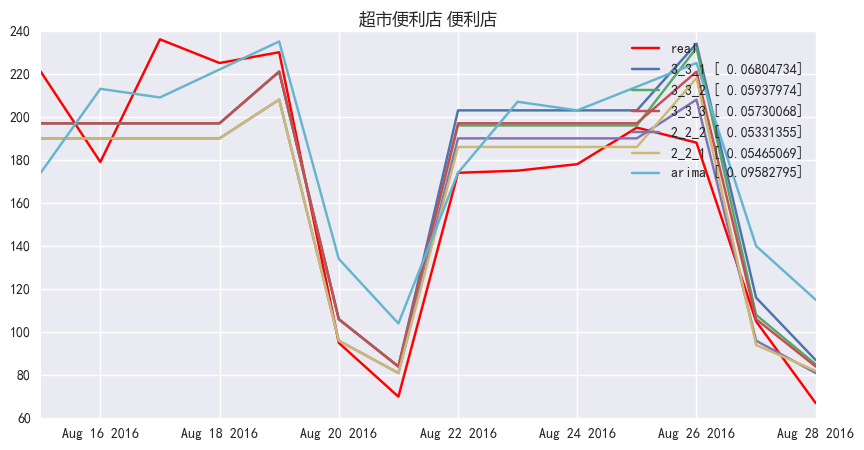

In [61]:
open_time = pd.to_datetime('2016-8-15')
end_time = pd.to_datetime('2016-8-28')
shop_id = 23
plotShopPayCounts(shop_id, [open_time, end_time], 
                  [datetime.timedelta(hours=0), datetime.timedelta(hours=23)], predict_dfs, mean_evaluation_dfs, names)

In [37]:
#3_3_1 \ 3_3_2 \ 2_2_2 \ 2_2_1 \ 3_3_3 \ arima

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [57]:
combine_df = pd.DataFrame()
for i in range(len(names)):
    combine_df[names[i]] = mean_evaluation_dfs[i]['evaluation']

In [58]:
min_index_df = combine_df.idxmin(1)

In [60]:
min_index_df

id
1       arima
2       3_3_3
3       arima
4       3_3_1
5       3_3_1
6       3_3_1
7       3_3_3
8       3_3_2
9       arima
10      arima
11      3_3_1
12      3_3_3
13      3_3_1
14      3_3_1
15      3_3_1
16      arima
17      3_3_3
18      arima
19      2_2_2
20      3_3_1
21      arima
22      3_3_2
23      2_2_2
24      2_2_2
25      3_3_3
26      arima
27      arima
28      2_2_2
29      3_3_3
30      3_3_2
        ...  
1971    3_3_1
1972    2_2_2
1973    3_3_1
1974    3_3_1
1975    2_2_1
1976    2_2_2
1977    3_3_1
1978    3_3_1
1979    arima
1980    3_3_2
1981    3_3_1
1982    3_3_3
1983    arima
1984    3_3_1
1985    3_3_3
1986    3_3_3
1987    3_3_1
1988    3_3_2
1989    2_2_2
1990    2_2_1
1991    3_3_2
1992    3_3_2
1993    arima
1994    3_3_1
1995    3_3_1
1996    arima
1997    3_3_3
1998    3_3_1
1999    3_3_2
2000    arima
dtype: object

In [72]:
diff_df = diff.to_frame()

In [76]:
diff_df[diff_df['evaluation'] > 0.01].sort_values('evaluation')

,evaluation
id,
1763,0.010038
1359,0.010065
456,0.010069
218,0.010130
1614,0.010182
902,0.010193
104,0.010193
1318,0.010199
1320,0.010261
